# Harmony Search Algorithms Applied to Portuguese Relation Extraction

In [1]:
import pickle

In [2]:
def save(data, file_name):
    with open(f"workspace/{file_name}.pkl", "wb") as file:
        pickle.dump(data, file)

In [3]:
def load(file_name):
    with open(f"workspace/{file_name}.pkl", "rb") as file:
        data = pickle.load(file)
    return data

## Load dataset

In [4]:
from source.datasets.dbpedia import DBpedia

In [5]:
dataset = DBpedia("data/DBpediaRelations-PT-0.2.txt")

In [6]:
print(f"number of samples: {len(dataset.data)}")

number of samples: 15392


In [7]:
print(f"number of positive samples: {sum(dataset.labels)}")

number of positive samples: 7696


In [8]:
dataset.data[0]

{'sentence': 'Albert Einstein nasceu na região alemã de Württemberg, na cidade de Ulm, numa família judaica.',
 'entity_1': 'Albert Einstein',
 'entity_2': 'Württemberg'}

## Create features

In [9]:
from source.features.tagger import Tagger

In [10]:
tagger = Tagger()

In [11]:
features_raw = tagger.tag(dataset.data)

100%|██████████| 15392/15392 [01:18<00:00, 196.72it/s]                                                                                             


In [12]:
save(features_raw, "features_raw")

In [13]:
features_raw = load("features_raw")

In [14]:
# Remove incorrect samples

data, labels, features = [], [], []
for item, label, feature in zip(dataset.data, dataset.labels, features_raw):
    if feature:
        data.append(item)
        labels.append(label)
        features.append(feature)

In [15]:
data[0]

{'sentence': 'Albert Einstein nasceu na região alemã de Württemberg, na cidade de Ulm, numa família judaica.',
 'entity_1': 'Albert Einstein',
 'entity_2': 'Württemberg'}

In [16]:
features[0]

{'between': [100, 85, 92, 84, 85]}

In [17]:
tagger.convert_tags_to_strings(features[0])

{'between': ['VERB', 'ADP', 'NOUN', 'ADJ', 'ADP']}

## Select data

In [18]:
import random
from sklearn.model_selection import train_test_split

In [19]:
random.seed(42)

In [20]:
# Resample due to time limitations

N_SAMPLES = 2000

index = [i for i in range(0, len(features))]
index_sample = random.sample(index, N_SAMPLES)
features_sample = [features[i] for i in index_sample]
labels_sample = [labels[i] for i in index_sample]

In [21]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features_sample,
    labels_sample,
    train_size=0.7,
    random_state=42
)

In [22]:
print(f"number of train samples: {len(features_train)}")
print(f"number of test samples: {len(features_test)}")

number of train samples: 1400
number of test samples: 600


In [23]:
print(f"number of positive train samples: {sum(labels_train)}")
print(f"number of positive test samples: {sum(labels_test)}")

number of positive train samples: 677
number of positive test samples: 308


## Original HS

In [24]:
from source.harmony_searches.original import OriginalHS

In [25]:
N_RUNS = 100
N_GENERATIONS = 500
N_HARMONIES = 50
N_PARAMETERS = 15
HMCR = 0.9
PAR = 0.5

In [26]:
original_hs = OriginalHS(
    n_runs=N_RUNS,
    n_generations=N_GENERATIONS,
    n_harmonies=N_HARMONIES,
    n_parameters=N_PARAMETERS,
    hmcr=HMCR,
    par=PAR
)

In [27]:
%%time

original_hs.fit(features_train, labels_train)

Wall time: 1h 47min 47s


In [28]:
original_hs.evaluate(features_test, labels_test)

{'f1': '0.6716 ± 0.02002',
 'precision': '0.7592 ± 0.0174',
 'recall': '0.6035 ± 0.03495'}

In [29]:
save(original_hs, "original_hs")

## Improved HS

In [30]:
from source.harmony_searches.improved import ImprovedHS

In [31]:
PAR_MIN = 0.01
PAR_MAX = 0.99

In [32]:
improved_hs = ImprovedHS(
    n_runs=N_RUNS,
    n_generations=N_GENERATIONS,
    n_harmonies=N_HARMONIES,
    n_parameters=N_PARAMETERS,
    hmcr=HMCR,
    par_min=PAR_MIN,
    par_max=PAR_MAX
)

In [33]:
%%time

improved_hs.fit(features_train, labels_train)

Wall time: 1h 48min 53s


In [34]:
improved_hs.evaluate(features_test, labels_test)

{'f1': '0.6495 ± 0.01738',
 'precision': '0.7756 ± 0.02656',
 'recall': '0.56 ± 0.02977'}

In [35]:
save(improved_hs, "improved_hs")

## Parameter Adaptive HS

In [36]:
from source.harmony_searches.parameter_adaptive import ParameterAdaptiveHS

In [37]:
HMCR_MIN = 0.70
HMCR_MAX = 0.99

In [38]:
parameter_adaptive_hs = ParameterAdaptiveHS(
    n_runs=N_RUNS,
    n_generations=N_GENERATIONS,
    n_harmonies=N_HARMONIES,
    n_parameters=N_PARAMETERS,
    hmcr_min=HMCR_MIN,
    hmcr_max=HMCR_MAX,
    par_min=PAR_MIN,
    par_max=PAR_MAX
)

In [39]:
%%time

parameter_adaptive_hs.fit(features_train, labels_train)

Wall time: 1h 47min


In [40]:
parameter_adaptive_hs.evaluate(features_test, labels_test)

{'f1': '0.6476 ± 0.01355',
 'precision': '0.7903 ± 0.03319',
 'recall': '0.5499 ± 0.0251'}

In [41]:
save(parameter_adaptive_hs, "parameter_adaptive_hs")

## Statistical Tests

In [4]:
original_hs = load("original_hs")

In [5]:
improved_hs = load("improved_hs")

In [6]:
parameter_adaptive_hs = load("parameter_adaptive_hs")

### Histories Visualization

In [7]:
from source.statistics import convergence, distribution, diversity

In [8]:
histories = {
    "original": original_hs.histories,
    "improved": improved_hs.histories,
    "parameter_adaptive": parameter_adaptive_hs.histories
}

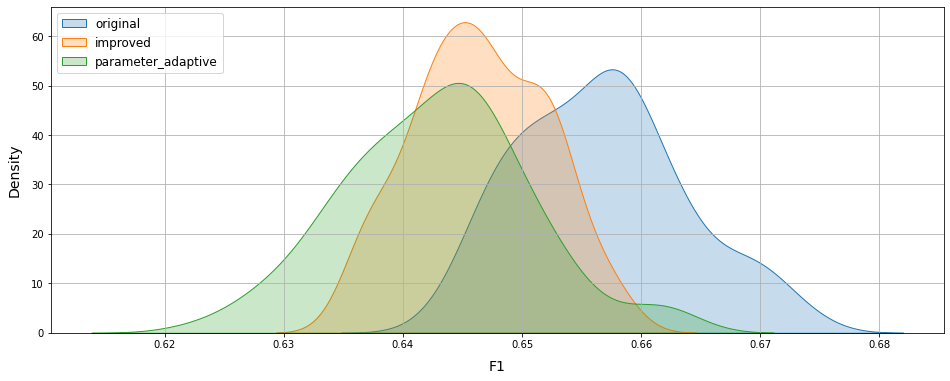

In [9]:
distribution.plot(histories)

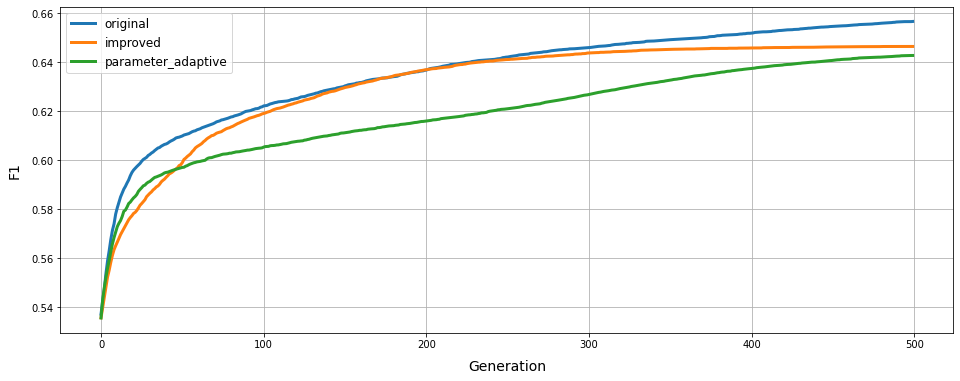

In [10]:
convergence.plot(histories)

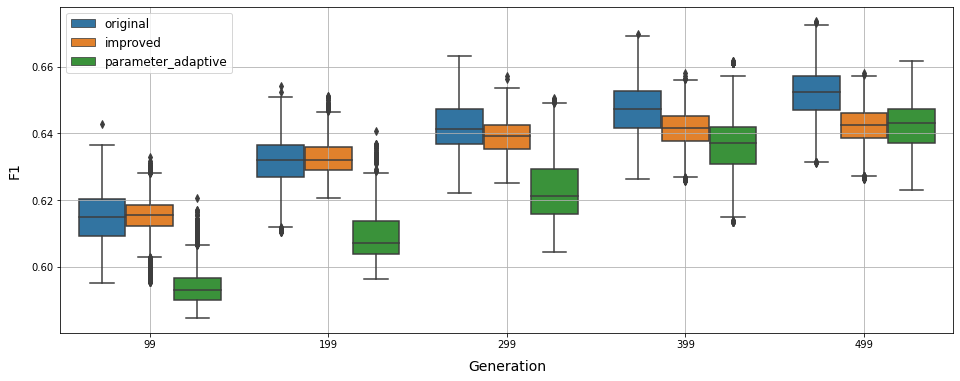

In [11]:
diversity.plot(histories)

### Shapito-Wilk Test

In [12]:
from source.statistics import shapiro_wilk

In [13]:
shapiro_wilk_test = {
    "original": shapiro_wilk.test(original_hs.histories),
    "improved": shapiro_wilk.test(improved_hs.histories),
    "parameter_adaptive": shapiro_wilk.test(parameter_adaptive_hs.histories)
}

In [14]:
shapiro_wilk_test

{'original': (0.9765, 0.0708),
 'improved': (0.9794, 0.1188),
 'parameter_adaptive': (0.9881, 0.5137)}

### Student's T-test

In [15]:
from source.statistics import t_ind

In [16]:
t_test = {
    "original - improved": t_ind.test(original_hs.histories, improved_hs.histories),
    "original - parameter_adaptive": t_ind.test(original_hs.histories, parameter_adaptive_hs.histories),
    "improved - parameter_adaptive": t_ind.test(improved_hs.histories, parameter_adaptive_hs.histories)
}

In [17]:
t_test

{'original - improved': (11.4663, 0.0),
 'original - parameter_adaptive': (13.2695, 0.0),
 'improved - parameter_adaptive': (3.857, 0.0002)}